# Protein secretion

In [1]:
from __future__ import print_function, division, absolute_import

import sys

import qminospy
from qminospy.me2 import ME_NLP

# python imports
from copy import copy
import re
from os.path import join
from collections import defaultdict
import pickle

# third party imports
import pandas
import cobra
from tqdm import tqdm

# COBRAme
import cobrame
from cobrame.util import building, mu, me_model_interface
from cobrame.io.json import save_json_me_model, save_reduced_json_me_model

# ECOLIme
import ecolime
from ecolime import (transcription, translation, flat_files, generics, formulas, compartments)
from ecolime.util.helper_functions import *

print(cobra.__file__)
print(cobrame.__file__)
print(ecolime.__file__)

/home/jt/Downloads/cobrapy-0.5.11/cobra/io/sbml3.py:24: UserWarning: Install lxml for faster SBML I/O
  warn("Install lxml for faster SBML I/O")
/home/jt/Downloads/cobrapy-0.5.11/cobra/io/__init__.py:12: UserWarning: cobra.io.sbml requires libsbml
  warn("cobra.io.sbml requires libsbml")


/home/jt/Downloads/cobrapy-0.5.11/cobra/__init__.py
/home/jt/UCSD/cobrame-master/cobrame/__init__.py
/home/jt/UCSD/bacillusme-master/ecolime/__init__.py


In [2]:
with open('../me_models/solution.pickle', 'rb') as solution:
    me = pickle.load(solution)

In [37]:
def add_demand(me,met_id,flux=0,fraction=0.01):
    all_rxns_in_model = [rxn.id for rxn in me.reactions]
    met = me.metabolites.get_by_id(met_id)
    rxn_id = 'DM_'+met_id
    weight = met.formula_weight/1000
    
    if rxn_id not in all_rxns_in_model:
        rxn = cobrame.MEReaction(rxn_id)
        me.add_reaction(rxn)
        if isinstance(met,cobrame.Metabolite):
            rxn.reaction = met_id + ' ->'
            mass_correction = 0
        elif isinstance(met,cobrame.Complex):
            mass_correction = 'protein_biomass'
            rxn.reaction = met_id + ' + ' + str(weight) + ' ' + mass_correction + ' ->'
        else:
            raise ValueError('Compound type not supported')
    else:
        rxn = me.reactions.get_by_id(rxn_id)
        
    if not flux and mass_correction:
        # fraction 1% of total group production
        group_production = me.solution.x_dict[mass_correction+'_to_biomass']
        flux = fraction * group_production / weight
    elif not flux:
        flux = 0.001
        
    rxn.lower_bound = flux
    rxn.upper_bound = flux
    
def single_sensitivity(me,met_id):
    add_demand(me,met_id)
    solve_me_model(me, 0.2, min_mu = .05, using_soplex=False, precision = 1e-6,verbosity=0)
    return met_id, me.solution.x_dict
    

In [38]:
def sensitivity(me,met_ids,NP=1,solution=0):
    if not solution:
        solve_me_model(me, 0.2, min_mu = .05, using_soplex=False, precision = 1e-6)
    flux_dict = dict()
    flux_dict['base'] = me.solution.x_dict
    
    if NP == 1:
        for met_id in met_ids:
            single_protein_sensitivity(me,met_id)
            flux_dict[met_id] = me.solution.x_dict
    else:
        import multiprocessing as mp
        pool = mp.Pool(NP)
        def collect_result(result):
            flux_dict[result[0]] = result[1]
            
        for met_id in met_ids:
            pool.apply_async(single_sensitivity, args=(me,met_id), callback=collect_result)
        pool.close()
        pool.join()   
    
    return flux_dict

In [39]:
complexes = [met.id for met in me.metabolites if isinstance(met,cobrame.Complex)]

In [ ]:
flux_dict = sensitivity(me,complexes, NP=20,solution=1)

In [ ]:
base_growth = flux_dict['base']['biomass_dilution']
S = []
MW = []
for protein_id,fluxes in flux_dict.items():
    new_growth = fluxes['biomass_dilution']
    if protein_id == 'base':
        continue
    
    protein_flux = fluxes['DM_'+protein_id]
    S.append((base_growth-new_growth)/protein_flux)
    
    protein = me.metabolites.get_by_id(protein_id)
    MW.append(protein.formula_weight/1000)

1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


In [ ]:
for protein_id,fluxes in flux_dict.items():
    

Text(0, 0.5, 'Sensitivity')

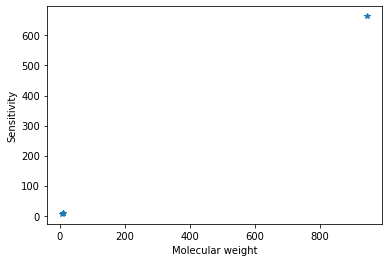

In [33]:
import matplotlib.pyplot as plt
plt.plot(MW,S,'*')
plt.xlabel('Molecular weight')
plt.ylabel('Sensitivity')